In [ ]:
import os
import numpy as np
import wfdb

window_size = 100

# Create a folder to save segmented data if it doesn't exist
if not os.path.exists('data_segmented'):
    os.makedirs('data_segmented')

record_path = '/home/andre/Code/IC/ecg-data/4_icentia11k/'
# Load the ECG record
for k in range(3):
    record_num = f'p{k:05d}'
    for i in range(1, 49):  # Skipping the first and last beats
        annotation_path = f"{record_path}/{record_num}_s{i:02d}"
        dat_path = f"{record_path}/{record_num}_s{i:02d}"
        
        # Load annotations
        annotation = wfdb.rdann(annotation_path, extension='atr')
        ann_sample = annotation.sample
        ann_symbol = annotation.symbol
        
        # Load ECG signal
        record = wfdb.rdrecord(dat_path)
        ecg_signal = record.p_signal.flatten()
        
        # Iterate over each heartbeat and segment it
        for j, (peak, beat_type) in enumerate(zip(ann_sample, ann_symbol)):
            start = max(0, peak - window_size)
            end = min(len(ecg_signal), peak + window_size)
            segment = ecg_signal[start:end]

            # Map beat type to N, S, V, or Q
            if beat_type in ['N', 'n']:
                beat_type = 'N'
            elif beat_type in ['S', 's']:
                beat_type = 'S'
            elif beat_type in ['V', 'v']:
                beat_type = 'V'
            elif beat_type in ['Q', 'q']:
                beat_type = 'Q'
            elif beat_type == '+':  # Ignore beats labeled as '+'
                continue

            # Save the segment as a new file in the data_segmented folder
            if not os.path.exists(f"data_segmented/{beat_type}"):
                os.makedirs(f"data_segmented/{beat_type}")
            file_name = f"data_segmented/{beat_type}/{record_num}_s{i:02d}_segment_{j:03d}_{beat_type}.csv"
            np.savetxt(file_name, segment, delimiter=",")
            print(f"Segment {j} ({beat_type}) for {record_num}_s{i:02d} saved as {file_name}")

# Initial vis

In [6]:
import wfdb
patient_id=0
segment_id=0
start=2000
length=1024
data_path = '/home/andre/Code/IC/ecg-data/3_norwegian-endurance'
filename = f'{data_path}/ath_001'
rec = wfdb.rdrecord(filename, sampfrom=start, sampto=start+length)
ann = wfdb.rdann(filename, "atr", sampfrom=start, sampto=start+length, shift_samps=True)
wfdb.plot_wfdb(rec, ann, plot_sym=True, figsize=(15,4))

FileNotFoundError: [Errno 2] No such file or directory: '/home/andre/Code/IC/ecg-data/3_norwegian-endurance/ath_001.atr'

In [13]:
import os
data_path = '/home/andre/Code/IC/ecg-data/3_norwegian-endurance'
ECGs = []
for ecgfilename in sorted(os.listdir(directory )):
    if ecgfilename.endswith(".dat"):
        ecg = wfdb.rdsamp(data_path  + ecgfilename.split(".")[0])
        ECGs.append(ecg)
ECGs = np.asarray(ECGs)

NameError: name 'directory' is not defined

# Salva em CSV

In [22]:
import wfdb
import os
import numpy as np
from aeon.datasets import write_to_tsfile
from sklearn.preprocessing import LabelEncoder


def split_heartbeats_to_csv(data_path, patient_id, segment_id, symbols):
    filename_prefix = f'p{patient_id:05d}_s{segment_id:02d}'
    filename_dat = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_atr = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_hea = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}.hea')
    
    rec = wfdb.rdrecord(filename_dat)
    ann = wfdb.rdann(filename_atr, 'atr')
    
    # Load header to get sampling frequency
    with open(filename_hea, 'r') as f:
        header_lines = f.readlines()
        fs_line = [line for line in header_lines if line.startswith(filename_prefix)][0]
        fs = int(fs_line.split()[2])
        
    # Calculate the number of samples for a 0.6 second window (adjust as needed)
    window_size = int(0.6 * fs)

    heartbeats = []
    labels = []
    
    for i, (beat_sample, symbol) in enumerate(zip(ann.sample, ann.symbol)):
        if symbol in symbols:
            beat_start = max(0, beat_sample - window_size // 2)
            beat_end = min(len(rec.p_signal), beat_sample + window_size // 2)
            beat_data = rec.p_signal[beat_start:beat_end, 0]
            
            heartbeats.append(np.array(beat_data))
            labels.append(symbol)
            
    heartbeats = np.array(heartbeats[1:-1], dtype='float64')
    labels = labels[1:-1]
    
    # Encode the labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    print(len(heartbeats), '---', len(labels))
    # Save heartbeats and labels to a .csv file
    write_to_tsfile(X=heartbeats, path=data_path, problem_name='HEART.ts', y=encoded_labels)
    print('Saved heartbeats and labels to', data_path)

# Example usage:
data_path = '/home/andre/Code/IC/ecg-data/4_icentia11k/p00/'
patient_id = 0
segment_id = 0
symbols = {
    'N': 'Normal',
    'S': 'ESSV (PAC)',
    'V': 'ESV (PVC)',
    'Q': 'Undefined'
}

split_heartbeats_to_csv(data_path, patient_id, segment_id, symbols)

6883 --- 6883


TypeError: object of type 'numpy.float64' has no len()

# Split cada batimento um arquivo

In [7]:
import wfdb
import os

def split_heartbeats(data_path, patient_id, segment_id, symbols):
    filename_prefix = f'p{patient_id:05d}_s{segment_id:02d}'
    filename_dat = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_atr = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_hea = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}.hea')
    
    rec = wfdb.rdrecord(filename_dat)
    ann = wfdb.rdann(filename_atr, 'atr')
    
    # Load header to get sampling frequency
    with open(filename_hea, 'r') as f:
        header_lines = f.readlines()
        fs_line = [line for line in header_lines if line.startswith(filename_prefix)][0]
        fs = int(fs_line.split()[2])
        
    # Calculate the number of samples for a 0.6 second window (adjust as needed)
    window_size = int(0.6 * fs)

    # Create directory to save beat segments if it doesn't exist
    save_dir = os.path.join(data_path, 'heartbeats')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i, (beat_sample, symbol) in enumerate(zip(ann.sample, ann.symbol)):
        if symbol in symbols:
            beat_start = max(0, beat_sample - window_size // 2)
            beat_end = min(len(rec.p_signal), beat_sample + window_size // 2)
            beat_data = rec.p_signal[beat_start:beat_end, 0]
            
            # Save the beat segment to a file
            save_path = os.path.join(data_path, 'heartbeats', f'{filename_prefix}_beat_{i:03d}_{symbol}.dat')
            with open(save_path, 'wb') as f:
                f.write(beat_data)
            print(f'Saved beat segment {i+1}')

# Example usage:
data_path = '/home/andre/Code/IC/ecg-data/4_icentia11k/p00/'
patient_id = 0
segment_id = 0
symbols = {
    'N': 'Normal',
    'S': 'ESSV (PAC)',
    'V': 'ESV (PVC)',
    'Q': 'Undefined'
}

split_heartbeats(data_path, patient_id, segment_id, symbols)

Saved beat segment 1
Saved beat segment 3
Saved beat segment 4
Saved beat segment 5
Saved beat segment 6
Saved beat segment 7
Saved beat segment 8
Saved beat segment 9
Saved beat segment 10
Saved beat segment 11
Saved beat segment 12
Saved beat segment 13
Saved beat segment 14
Saved beat segment 15
Saved beat segment 16
Saved beat segment 17
Saved beat segment 18
Saved beat segment 19
Saved beat segment 20
Saved beat segment 21
Saved beat segment 22
Saved beat segment 23
Saved beat segment 24
Saved beat segment 25
Saved beat segment 26
Saved beat segment 27
Saved beat segment 28
Saved beat segment 29
Saved beat segment 30
Saved beat segment 31
Saved beat segment 32
Saved beat segment 33
Saved beat segment 34
Saved beat segment 35
Saved beat segment 36
Saved beat segment 37
Saved beat segment 38
Saved beat segment 39
Saved beat segment 40
Saved beat segment 41
Saved beat segment 42
Saved beat segment 43
Saved beat segment 44
Saved beat segment 45
Saved beat segment 46
Saved beat segment

# Ve cada arquivo segmentado

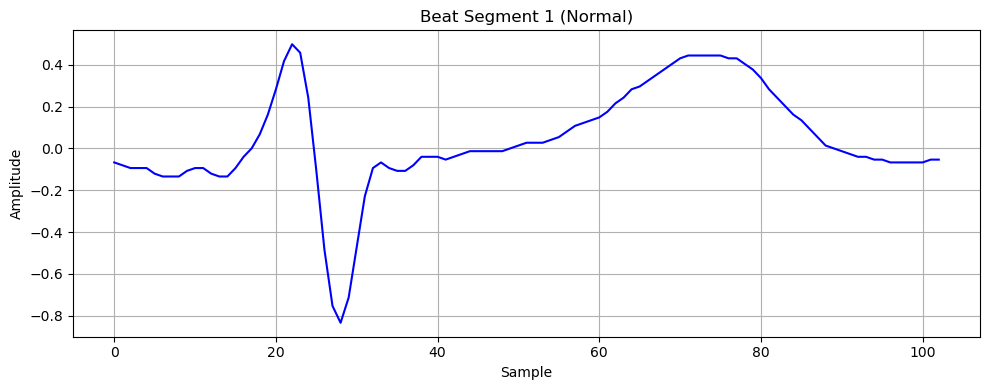

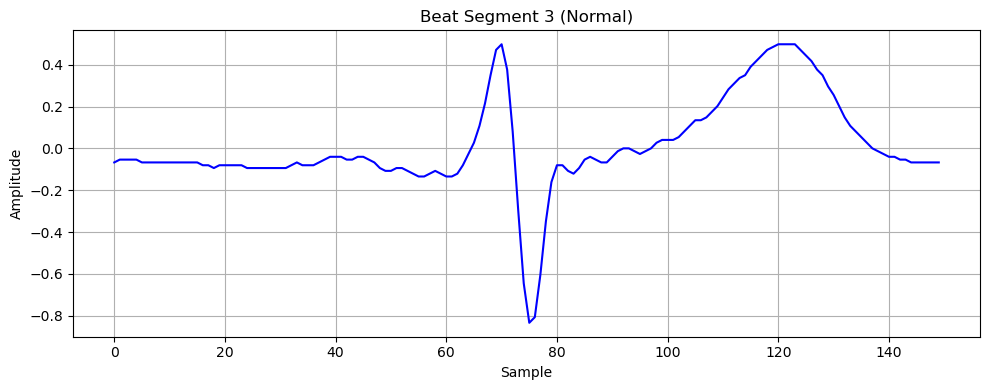

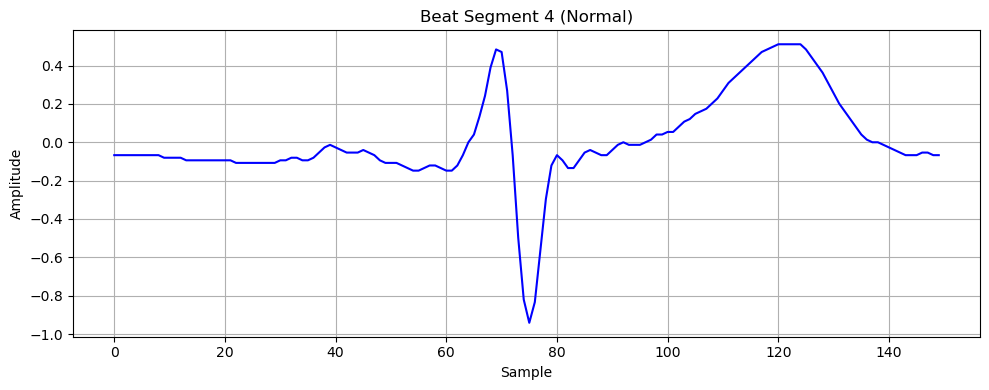

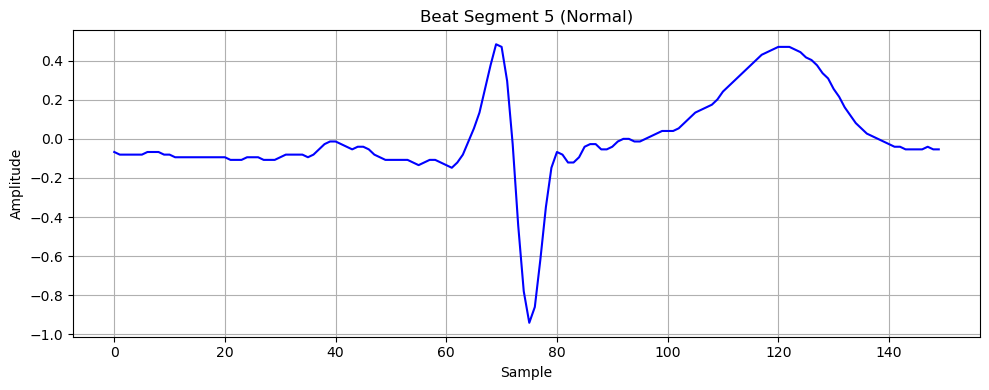

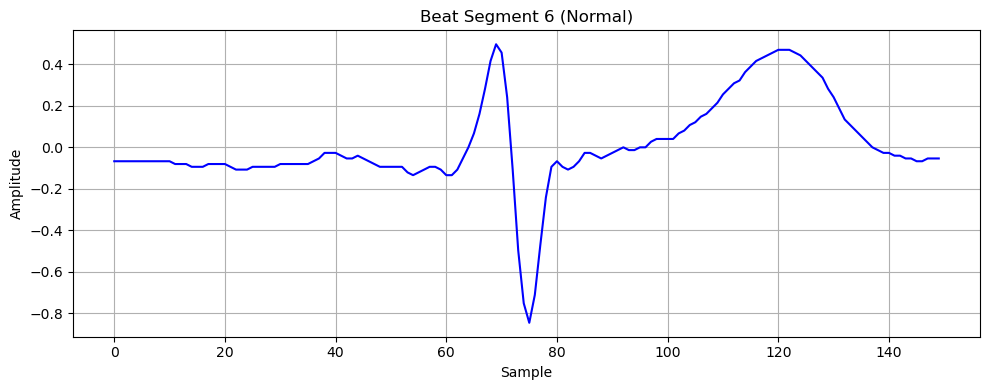

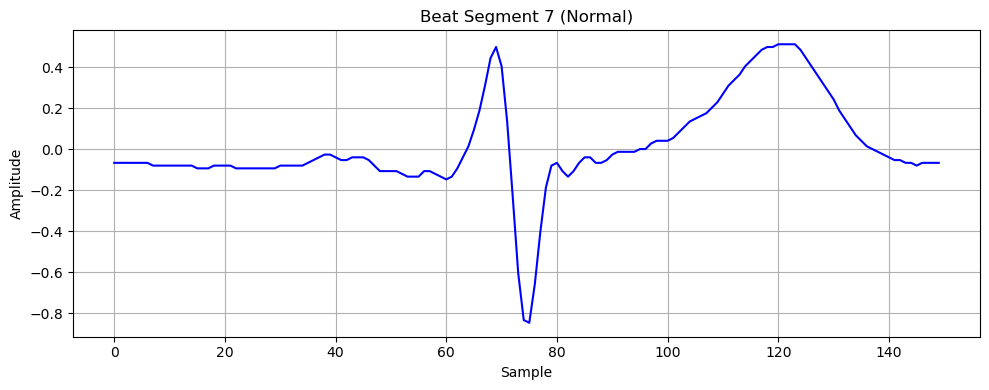

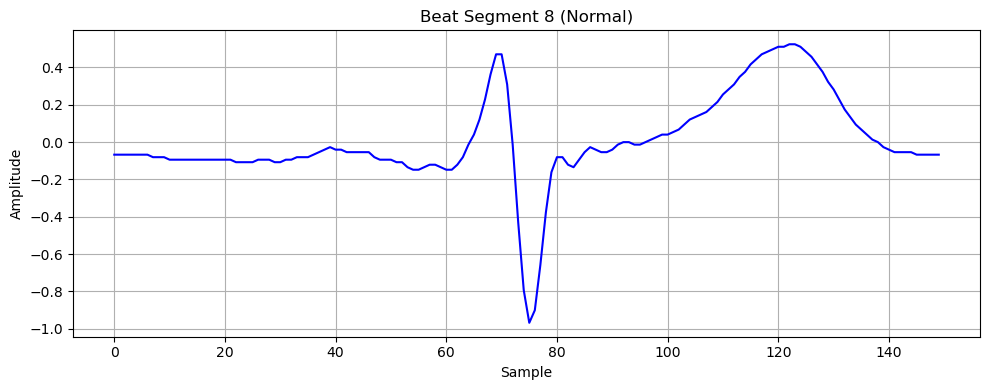

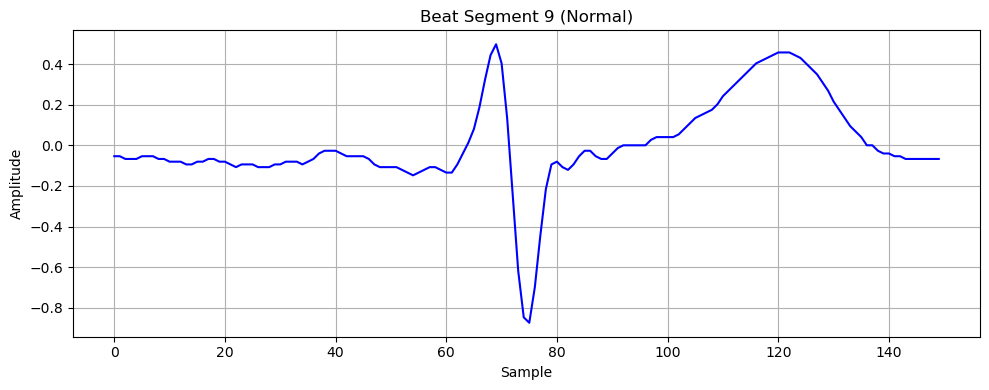

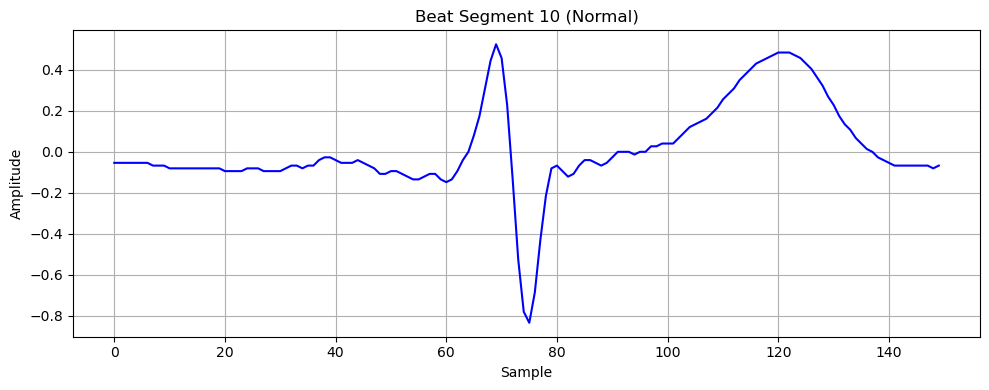

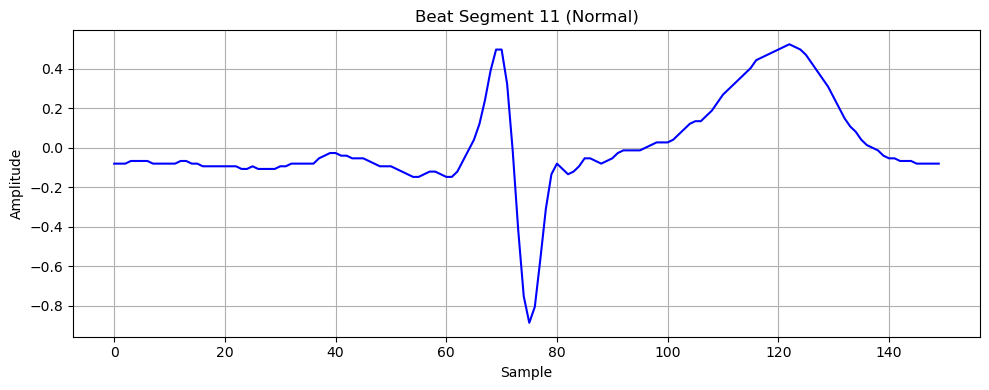

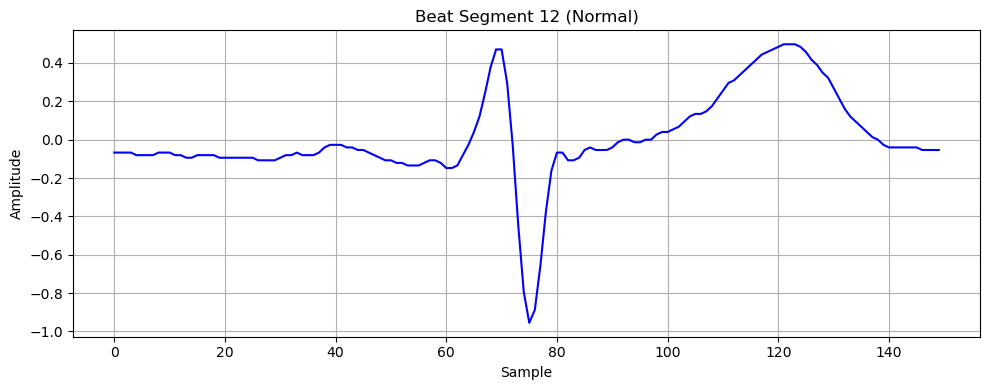

KeyboardInterrupt: 

In [4]:
import wfdb
import os
import matplotlib.pyplot as plt

def visualize_heartbeats(data_path, patient_id, segment_id, symbols):
    filename_prefix = f'p{patient_id:05d}_s{segment_id:02d}'
    filename_dat = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_atr = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_hea = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}.hea')
    
    rec = wfdb.rdrecord(filename_dat)
    ann = wfdb.rdann(filename_atr, 'atr')
    
    # Load header to get sampling frequency
    with open(filename_hea, 'r') as f:
        header_lines = f.readlines()
        fs_line = [line for line in header_lines if line.startswith(filename_prefix)][0]
        fs = int(fs_line.split()[2])
        
    # Calculate the number of samples for a 0.6 second window (adjust as needed)
    window_size = int(0.6 * fs)
    
    # Create directory to save beat segments if it doesn't exist
    save_dir = os.path.join(data_path, 'heartbeats')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i, (beat_sample, symbol) in enumerate(zip(ann.sample, ann.symbol)):
        if symbol in symbols:
            beat_start = max(0, beat_sample - window_size // 2)
            beat_end = min(len(rec.p_signal), beat_sample + window_size // 2)
            beat_data = rec.p_signal[beat_start:beat_end, 0]
            
            # Visualize the beat segment along with its symbol
            plt.figure(figsize=(10, 4))
            plt.plot(beat_data, color='blue')
            plt.title(f'Beat Segment {i+1} ({symbols[symbol]})')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

# Example usage:
data_path = '/home/andre/Code/IC/ecg-data/4_icentia11k/p00/'
patient_id = 0
segment_id = 0
symbols = {
    'N': 'Normal',
    'S': 'ESSV (PAC)',
    'V': 'ESV (PVC)',
    'Q': 'Undefined'
}

visualize_heartbeats(data_path, patient_id, segment_id, symbols)

In [2]:
import wfdb
import os
import numpy as np
from aeon import TimeSeriesDataset, Segment

def split_heartbeats(data_path, patient_id, segment_id, symbols):
    filename_prefix = f'p{patient_id:05d}_s{segment_id:02d}'
    filename_dat = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_atr = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_hea = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}.hea')
    
    rec = wfdb.rdrecord(filename_dat)
    ann = wfdb.rdann(filename_atr, 'atr')
    
    # Load header to get sampling frequency
    with open(filename_hea, 'r') as f:
        header_lines = f.readlines()
        fs_line = [line for line in header_lines if line.startswith(filename_prefix)][0]
        fs = int(fs_line.split()[2])
        
    # Calculate the number of samples for a 0.6 second window (adjust as needed)
    window_size = int(0.6 * fs)

    # Create directory to save beat segments if it doesn't exist
    save_dir = os.path.join(data_path, 'heartbeats')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    segments = []
    
    for i, (beat_sample, symbol) in enumerate(zip(ann.sample, ann.symbol)):
        if symbol in symbols:
            beat_start = max(0, beat_sample - window_size // 2)
            beat_end = min(len(rec.p_signal), beat_sample + window_size // 2)
            beat_data = rec.p_signal[beat_start:beat_end, 0]
            
            # Create a Segment object
            segment = Segment(data=beat_data, label=symbols[symbol], fs=fs)
            segments.append(segment)
            print(f'Processed beat segment {i+1}')

    # Create TimeSeriesDataset
    dataset = TimeSeriesDataset(segments)
    dataset.save(os.path.join(data_path, 'heartbeats_aeon_dataset'))

# Example usage:
data_path = '/home/andre/Code/IC/ecg-data/4_icentia11k/p00/'
patient_id = 0
segment_id = 0
symbols = {
    'N': 'Normal',
    'S': 'ESSV (PAC)',
    'V': 'ESV (PVC)',
    'Q': 'Undefined'
}

split_heartbeats(data_path, patient_id, segment_id, symbols)

ImportError: cannot import name 'TimeSeriesDataset' from 'aeon' (/home/andre/anaconda3/lib/python3.11/site-packages/aeon/__init__.py)

In [6]:
import wfdb
import os
import numpy as np
from aeon import TimeSeriesDataset, Segment

def split_heartbeats(data_path, patient_id, segment_id, symbols):
    filename_prefix = f'p{patient_id:05d}_s{segment_id:02d}'
    filename_dat = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_atr = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}')
    filename_hea = os.path.join(data_path, f'p{patient_id:05d}', f'{filename_prefix}.hea')
    
    rec = wfdb.rdrecord(filename_dat)
    ann = wfdb.rdann(filename_atr, 'atr')
    
    # Load header to get sampling frequency
    with open(filename_hea, 'r') as f:
        header_lines = f.readlines()
        fs_line = [line for line in header_lines if line.startswith(filename_prefix)][0]
        fs = int(fs_line.split()[2])
        
    # Calculate the number of samples for a 0.6 second window (adjust as needed)
    window_size = int(0.6 * fs)

    # Create directory to save beat segments if it doesn't exist
    save_dir = os.path.join(data_path, 'heartbeats')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    segments = []
    
    for i, (beat_sample, symbol) in enumerate(zip(ann.sample, ann.symbol)):
        if symbol in symbols:
            beat_start = max(0, beat_sample - window_size // 2)
            beat_end = min(len(rec.p_signal), beat_sample + window_size // 2)
            beat_data = rec.p_signal[beat_start:beat_end, 0]
            
            # Create a Segment object
            segment = Segment(data=beat_data, label=symbols[symbol], fs=fs)
            segments.append(segment)
            print(f'Processed beat segment {i+1}')

    # Create TimeSeriesDataset
    dataset = TimeSeriesDataset(segments)
    dataset.save(os.path.join(data_path, 'heartbeats_aeon_dataset'))

# Example usage:
data_path = '/home/andre/Code/IC/ecg-data/4_icentia11k/p00/'
patient_id = 0
segment_id = 0
symbols = {
    'N': 'Normal',
    'S': 'ESSV (PAC)',
    'V': 'ESV (PVC)',
    'Q': 'Undefined'
}

split_heartbeats(data_path, patient_id, segment_id, symbols)


ImportError: cannot import name 'TimeSeriesDataset' from 'aeon' (/home/andre/anaconda3/lib/python3.11/site-packages/aeon/__init__.py)

# Aeon

In [7]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from utils.functions_cls import *
import pandas as pd
from aeon.datasets.tsc_data_lists import univariate_equal_length as dataset_list, univariate2015
from aeon.datasets._data_loaders import load_classification
# from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from aeon.datasets._data_loaders import load_classification
# from aeon.datasets.tsc_data_lists import univariate_equal_length as dataset_list
# from pytorch_lightning.loggers.wandb import WandbLogger

# Loading the CUSTOM MODELS into a dict
from models import deeplearning_classifier as custom_estimator

# Experiments and parameters
NUM_EXPERIMENTS = 1
NUM_EPOCHS = 1000
LR = 1e-1
BATCH_SIZE = 16
HIDDEN_CHANNELS = 128
ACTIVATION = nn.ReLU()

# Finished Models list
finished_models = [
    # 'MLPClassifier',
    # 'FCNClassifier',
    # 'ResNetClassifier',
    # 'InceptionTimeClassifier',
]


# Logger
# wandb_logger = WandbLogger(log_model="all", project="ActivationFunctions")

results_dict = {
    'dataset': [],
    'model': [],
    'experiment': [],
    'acc': [],
    'f1': []
}

for dataset_name in univariate2015:
    if dataset_name in datasets: continue
    print('====== DATASET:', dataset_name, "======")

    X_train, y_train = load_classification(dataset_name, split='train')
    X_test, y_test = load_classification(dataset_name, split='test')
    train_label_mapping = {label: idx for idx, label in enumerate(set(y_train))}
    num_classes = len(set(y_train))

    # Lenghts and dimensions
    try:
        sequence_len = X_train.shape[-1]
    except IndexError:
        sequence_len = X_train[0].shape[-1]
    dimension_num = X_train.shape[1]

    # Datasets
    train_dataset = TimeSeriesDataset(X_train, y_train, label_mapping=train_label_mapping)
    test_dataset = TimeSeriesDataset(X_test, y_test, label_mapping=train_label_mapping)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    

    for current_model in custom_estimator:
        if current_model in finished_models: continue

        print('***** MODEL:', current_model, "*****")

        for experiment in range(NUM_EXPERIMENTS):
            
            # Loading Models and Parameters
            model_params = {
                'sequence_len': sequence_len,
                'dimension_num': dimension_num,
                'num_classes': num_classes,
                'out_channels': 128,
                'hidden_channels': HIDDEN_CHANNELS,
                'activation': ACTIVATION,
            }
            # checkpoint_callback = ModelCheckpoint(dirpath='experiments', filename=f"cls_{current_model}_{dataset_name}_{experiment}", verbose=True, monitor='train_loss')
            model = custom_estimator[current_model](**model_params)
            model_classifier = TimeSeriesClassifier(model=model, optimizer=torch.optim.Adadelta(model.parameters(), lr=LR, eps=1e-8))

            # Trainer 
            trainer = Trainer(
                max_epochs=NUM_EPOCHS, 
                accelerator='gpu',
                devices=-1,
                # logger=wandb_logger, 
                # callbacks=[checkpoint_callback],
                # enable_model_summary = False
            )
            
            trainer.fit(model_classifier, train_loader)
            results = trainer.test(model_classifier, test_loader)
            
            results_dict['dataset'].append(dataset_name)
            results_dict['model'].append(current_model)
            results_dict['experiment'].append(experiment)
            results_dict['acc'].append(results[0]['accuracy'])
            results_dict['f1'].append(results[0]['f1'])
            
            results_dataframe = pd.DataFrame(results_dict)
            results_dataframe.to_csv('./ucr_classification.csv', index=False)
            


            # Finish logging
            # wandb_logger.log_metrics({"model": current_model, "dataset": dataset_name, "experiment": experiment})
            # wandb_logger.finalize("success")

            # Free GPU
            # device = torch.device("cpu")
            # model_classifier.to(device)
            # model = None
            # model_classifier = None
            # torch.cuda.empty_cache()

KeyboardInterrupt: 